In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import traingset as dl
import seaborn as sns

import resnet
import STCGRU 
import RESGRU
import PSDCnn


Sequential output shape:	 torch.Size([5, 64, 2, 250])
Sequential output shape:	 torch.Size([5, 64, 2, 250])
Sequential output shape:	 torch.Size([5, 128, 1, 125])
Sequential output shape:	 torch.Size([5, 256, 1, 63])
Sequential output shape:	 torch.Size([5, 512, 1, 32])
AdaptiveAvgPool2d output shape:	 torch.Size([5, 512, 1, 1])
Flatten output shape:	 torch.Size([5, 512])
Linear output shape:	 torch.Size([5, 2])
tcnn output shape:	 torch.Size([5, 1, 19, 128])
scnn output shape:	 torch.Size([5, 76, 128])
gru output shape:	 torch.Size([5, 2, 32])
Flatten output shape:	 torch.Size([5, 64])
Linear output shape:	 torch.Size([5, 2])
torch.Size([8, 2])


In [2]:

# 定义脑区索引
from itertools import combinations

# 初始脑区定义
regions = {
    "prefrontal": [0, 1, 2, 3, 10, 11, 16],
    "central": [4, 5, 17],
    "temporal": [12, 13, 14, 15],
    "parietal": [6, 7, 18],
    "occipital": [8, 9]
}

# 前额叶_中央叶_颞叶_顶叶_枕叶

# 自动生成多脑区组合
def generate_combinations(regions, sizes):
    combined_regions = {}
    region_names = list(regions.keys())
    # 遍历指定组合大小
    for size in sizes:
        for combination in combinations(region_names, size):
            combined_name = "_".join(combination)  # 组合名称
            combined_indices = sorted(set().union(*(regions[region] for region in combination)))  # 合并去重
            combined_regions[combined_name] = combined_indices
    return combined_regions
# 生成所有二、三、四脑区组合
regions = generate_combinations(regions, sizes=[1,2, 3, 4,5])
# 动态获取变量值
name = locals()
seed = 66
dl.seed_everything(seed)

batch_size = 64
total_fold = 10  # 10折
partition = "prefrontal_central_temporal_parietal_occipital"
model_name = "resgru_tnb"
dataset_name = "EEGData"
num_channels = len(regions[partition])
model_type = partition
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_acc_sum = 0
results_sum = []
labels_test_sum = []
results_PR_sum = []

acc_list = []
kappa_list = []
sensitivity_list = []
specificity_list = []
precision_list = []
f1_list = []

for i in range(total_fold):
    test_data_combine = torch.load(dataset_name +"/"+partition+"/TestData/test_data_"+ str(i + 1) + "_fold_with_seed_" + str(seed) + ".pth", weights_only=False)
    test_loader = DataLoader(dataset=test_data_combine,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=8)
    # model = STCGRU.model(num_channels).to(device)
    model = RESGRU.EEG_ResNet_GRU(num_channels=num_channels).to(device)
    # model = PSDCnn.PSDNet(input_channels=num_channels).to(device)
    model_loc =  model_name+'/'+partition+"/"+str(i + 1) + "_fold_model_parameter_with_seed_" + str(seed) + ".pth"
    model_dict = torch.load(model_loc,weights_only=True)
    model.load_state_dict(model_dict)
    
    '''测试'''
    acc_average, results, labels_test, results_PR = dl.model_predict(i,test_loader,model)
    results_sum.extend(results)
    labels_test_sum.extend(labels_test)
    results_PR_sum.extend(results_PR)
    name['test_acc_average_' + str(i + 1)] = acc_average

    confusion_matrix_single = confusion_matrix(labels_test, results, labels=[0, 1])
    kappa_single = cohen_kappa_score(labels_test, results)
    sensitivity_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[0, 1])  # 灵敏度（召回率）
    specificity_single = confusion_matrix_single[1, 1] / (confusion_matrix_single[1, 1] + confusion_matrix_single[1, 0])  # 特异度
    precision_single = confusion_matrix_single[0, 0] / (confusion_matrix_single[0, 0] + confusion_matrix_single[1, 0])  # 查准率
    F1_single = 2 * precision_single * sensitivity_single / (precision_single + sensitivity_single)  # F1值
    acc_list.append(acc_average)
    kappa_list.append(kappa_single)
    sensitivity_list.append(sensitivity_single)
    specificity_list.append(specificity_single)
    precision_list.append(precision_single)
    f1_list.append(F1_single)

    print(model_type + " 第%d折交叉验证测试集准确率: %.4f，kappa值：%.4f，灵敏度：%.4f，特异度：%.4f，查准率：%.4f，F1值：%.4f"
        % (i+1, acc_average, kappa_single, sensitivity_single, specificity_single, precision_single, F1_single))
import pandas as pd

# 保存每一折和整体平均数据到csv
metrics_dict = {
    'Fold': [f'Fold {i+1}' for i in range(total_fold)] + ['Mean'],
    'Accuracy': acc_list + [np.mean(acc_list)],
    'Kappa': kappa_list + [np.mean(kappa_list)],
    'Sensitivity': sensitivity_list + [np.mean(sensitivity_list)],
    'Specificity': specificity_list + [np.mean(specificity_list)],
    'Precision': precision_list + [np.mean(precision_list)],
    'F1': f1_list + [np.mean(f1_list)],
}
df_metrics = pd.DataFrame(metrics_dict)
csv_path = f"result/{model_name}/{partition}_metrics.csv"
df_metrics.to_csv(csv_path, index=False)
print(f"保存至 {csv_path}")

# 保存labels_test_sum和results_PR_sum到csv
df_pred = pd.DataFrame({
    "label": labels_test_sum,
    "prob": [x[1] if isinstance(x, (list, np.ndarray)) and len(x) > 1 else x for x in results_PR_sum]
})
pred_csv_path = f"result/{model_name}/{partition}_labels_probs.csv"
df_pred.to_csv(pred_csv_path, index=False)
print(f"保存至 {pred_csv_path}")

prefrontal_central_temporal_parietal_occipital 第1折交叉验证测试集准确率: 0.9878，kappa值：0.9745，灵敏度：0.9985，特异度：0.9776，查准率：0.9747，F1值：0.9864
prefrontal_central_temporal_parietal_occipital 第2折交叉验证测试集准确率: 0.9918，kappa值：0.9830，灵敏度：0.9985，特异度：0.9855，查准率：0.9835，F1值：0.9909
prefrontal_central_temporal_parietal_occipital 第3折交叉验证测试集准确率: 0.9932，kappa值：0.9858，灵敏度：0.9909，特异度：0.9947，查准率：0.9939，F1值：0.9924
prefrontal_central_temporal_parietal_occipital 第4折交叉验证测试集准确率: 0.9946，kappa值：0.9886，灵敏度：0.9939，特异度：0.9947，查准率：0.9939，F1值：0.9939
prefrontal_central_temporal_parietal_occipital 第5折交叉验证测试集准确率: 0.9946，kappa值：0.9886，灵敏度：0.9954，特异度：0.9934，查准率：0.9924，F1值：0.9939
prefrontal_central_temporal_parietal_occipital 第6折交叉验证测试集准确率: 0.9821，kappa值：0.9858，灵敏度：0.9847，特异度：1.0000，查准率：1.0000，F1值：0.9923
prefrontal_central_temporal_parietal_occipital 第7折交叉验证测试集准确率: 0.9952，kappa值：0.9901，灵敏度：1.0000，特异度：0.9908，查准率：0.9894，F1值：0.9947
prefrontal_central_temporal_parietal_occipital 第8折交叉验证测试集准确率: 0.9980，kappa值：0.9957，灵敏度：0.9985，特异度：0.9974，查准率：0.

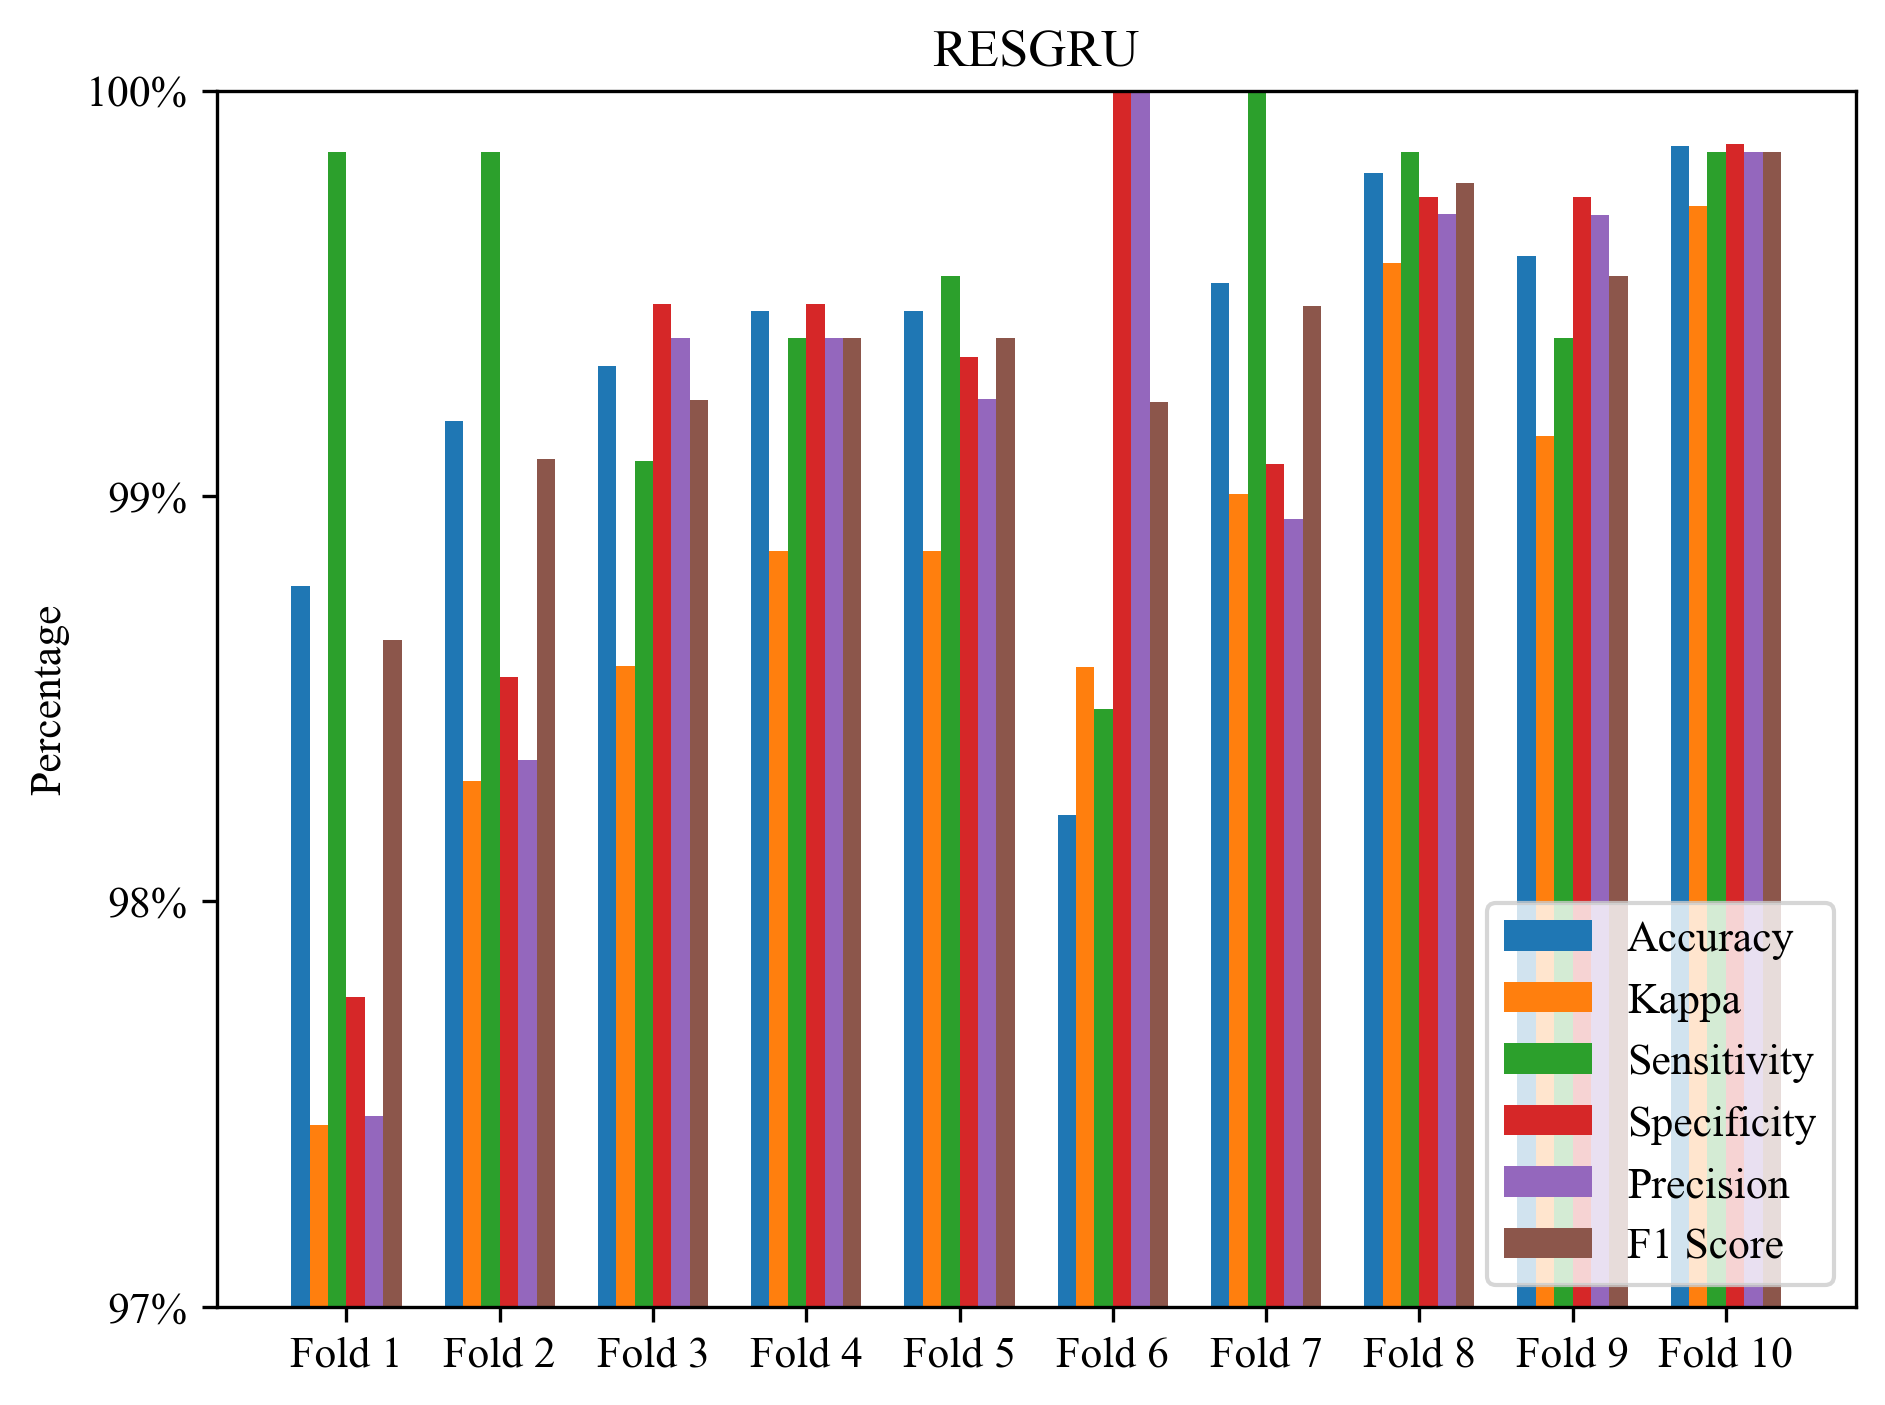

In [3]:
# X 轴的位置
x = np.arange(total_fold)
width = 0.12  # 每个条形的宽度，根据指标数量调整


# 设置字体和字号
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10.5

# 创建图形和子图对象
fig, ax = plt.subplots(dpi=300) # 调整图形大小以便容纳图例

# 绘制每个指标的条形图
ax.bar(x - 2.5 * width, acc_list, width, label='Accuracy')
ax.bar(x - 1.5 * width, kappa_list, width, label='Kappa')
ax.bar(x - 0.5 * width, sensitivity_list, width, label='Sensitivity')
ax.bar(x + 0.5 * width, specificity_list, width, label='Specificity')
ax.bar(x + 1.5 * width, precision_list, width, label='Precision')
ax.bar(x + 2.5 * width, f1_list, width, label='F1 Score')


# 设置图形的标题
ax.set_title(f'RESGRU') # 图形标题


# 设置 Y 轴的标签
ax.set_ylabel('Percentage') # Y轴标签


# 设置 X 轴的刻度和标签
ax.set_xticks(x)
ax.set_xticklabels([f'Fold {i+1}' for i in range(total_fold)])

# **** 这是关键步骤：设置 Y 轴的范围 ****
ax.set_ylim(0.97, 1.0)  # 将 Y 轴范围设置为 0.95 到 1.0 (即 95% 到 100%)

# 为了让 Y 轴刻度更清晰地显示百分比，我们可以自定义刻度
# 例如，每隔 0.01 (1%) 显示一个刻度
y_ticks = np.arange(0.97, 1.001, 0.01) # 从0.95到1.0，步长为0.01
ax.set_yticks(y_ticks)
# 将刻度标签格式化为百分比形式 (可选)
ax.set_yticklabels([f'{tick*100:.0f}%' for tick in y_ticks])


# 添加图例
ax.legend(loc='lower right') # 将图例放在右下角，避免遮挡条形图

# 自动调整布局，防止标签重叠
plt.tight_layout()


plt.savefig("1.png", dpi=300,bbox_inches='tight')
# 显示图形
plt.show()

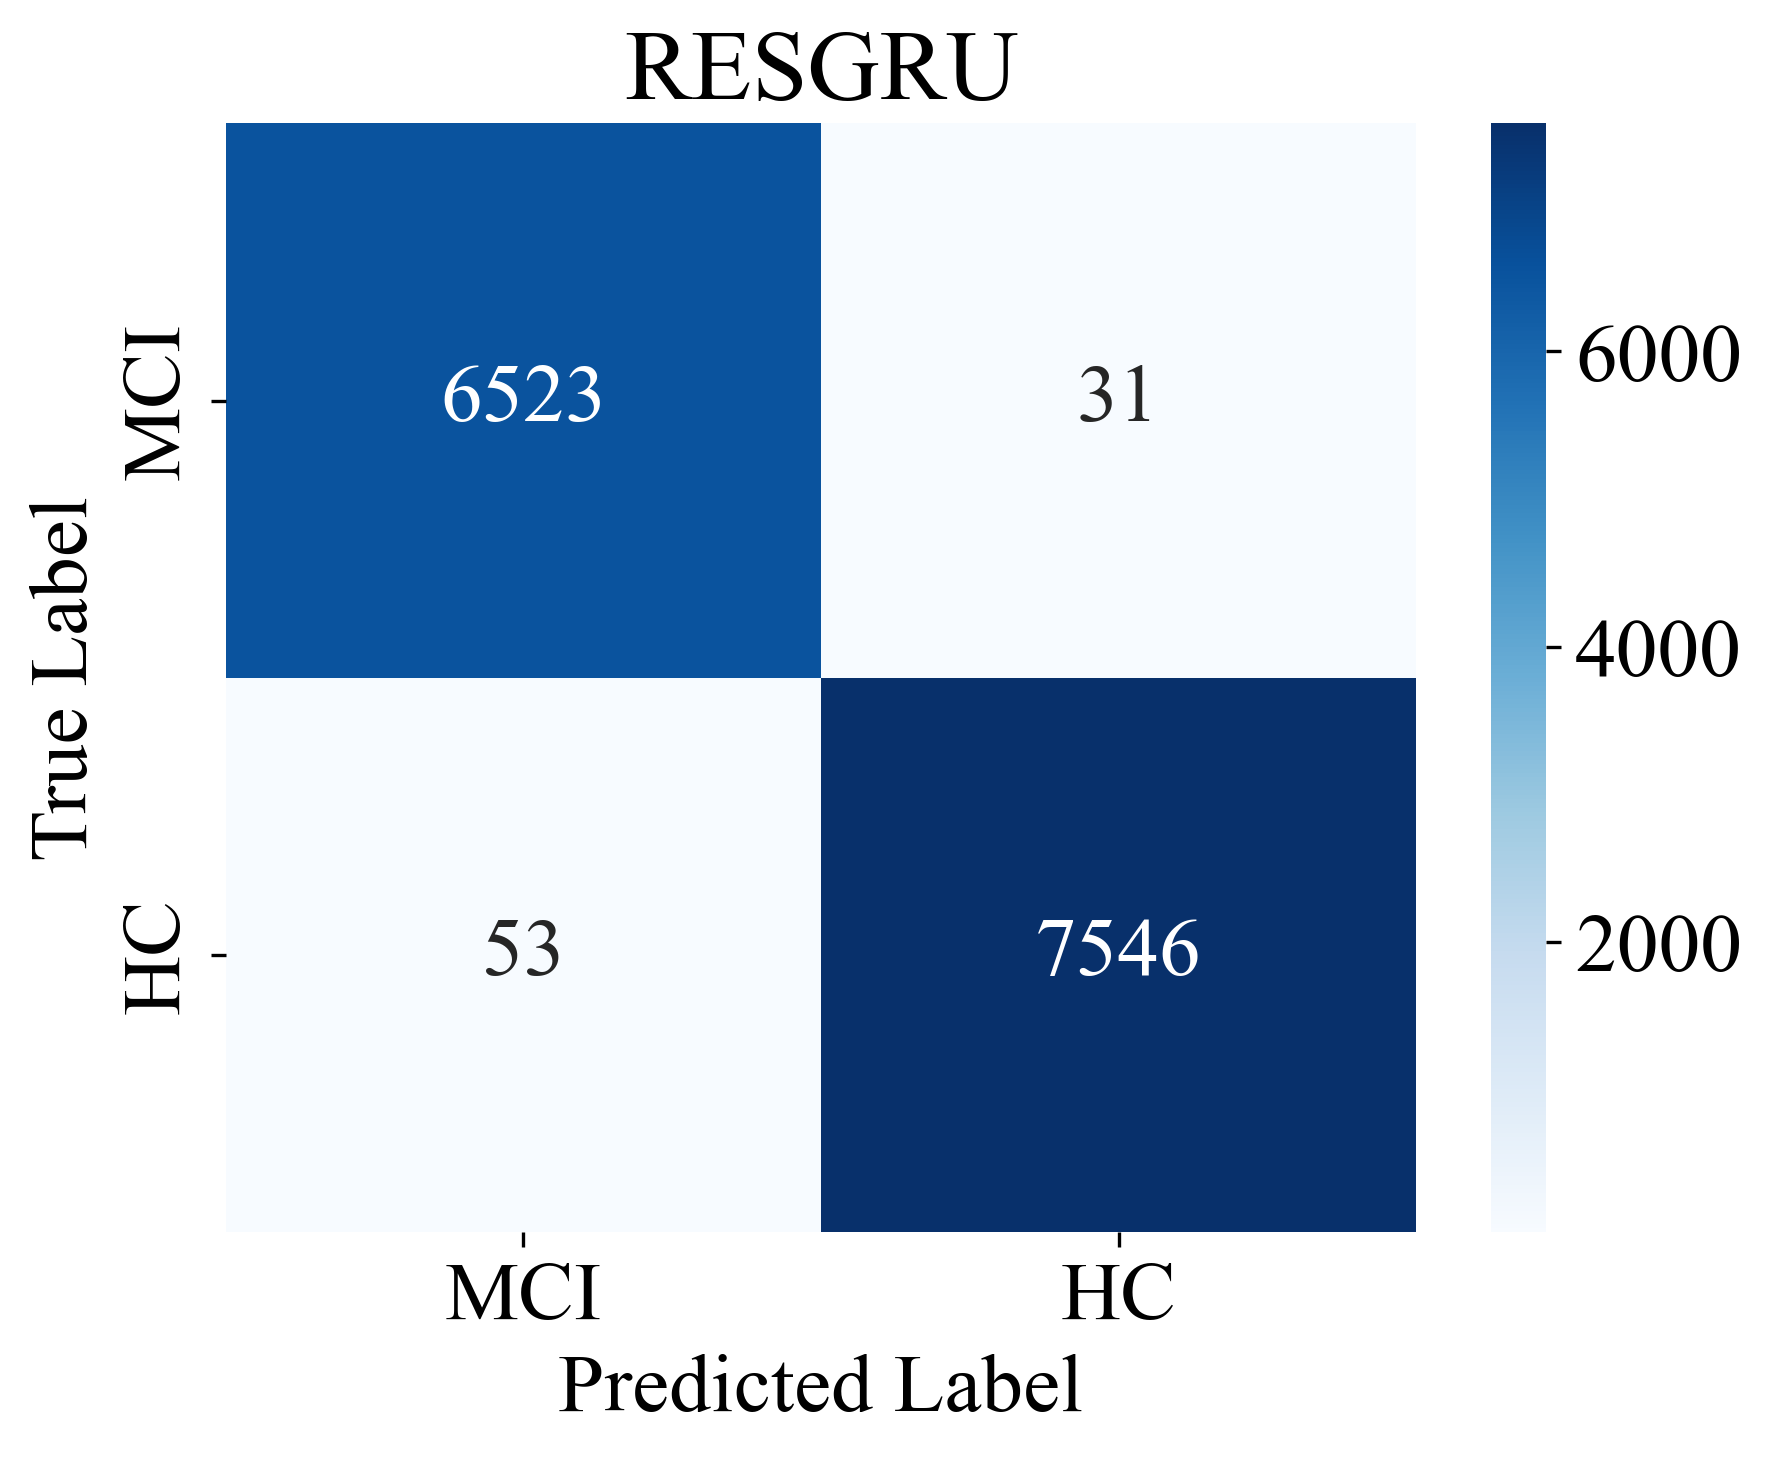

prefrontal_central_temporal_parietal_occipital 10折交叉验证平均测试集准确率: 0.9932 ± 0.0047, kappa值：0.9881, 灵敏度：0.9953, 特异度：0.9930, 查准率：0.9919, F1值：0.9936


In [6]:
test_acc_list = []

# # 收集测试集准确率
# for i in range(total_fold):
#     test_acc_list.append(name[f'test_acc_average_{i + 1}'])
#     del name[f'test_acc_average_{i + 1}']  # 删除字典中的键

# # 将列表转换为NumPy数组
# test_acc_sum = np.array(test_acc_list)

# 计算最终准确率和标准差
test_acc_final = np.mean(test_acc_sum)
test_acc_std = np.std(test_acc_sum)

# 计算混淆矩阵和相关指标
conf_matrix = confusion_matrix(labels_test_sum, results_sum, labels=[0, 1])
kappa = cohen_kappa_score(labels_test_sum, results_sum)

# 从混淆矩阵计算各项指标
sensitivity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])  # 灵敏度（召回率）
specificity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])  # 特异度
precision = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])  # 查准率
F1 = 2 * precision * sensitivity / (precision + sensitivity)  # F1值

# 绘制混淆矩阵
def plot_confusion_matrix(conf_matrix, classes, title='SVM '):
    plt.figure(dpi=300)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(conf_matrix, classes=['MCI', 'HC'], title=f'RESGRU')

# 打印结果
print(f"{model_type} {total_fold}折交叉验证平均测试集准确率: {test_acc_final:.4f} ± {test_acc_std:.4f}, "
      f"kappa值：{kappa:.4f}, 灵敏度：{sensitivity:.4f}, 特异度：{specificity:.4f}, "
      f"查准率：{precision:.4f}, F1值：{F1:.4f}")